# Table of Content
* [Read-CSV](#Read-CSV)
* [Helper-Functions](#Helper-Functions)
  * [Helper-function-1:-Generic-Modelling-Fuction](#Helper-function-1:-Generic-Modelling-Fuction)
  * [Helper-function-2:--Evaluation](#Helper-function-2:--Evaluation)
* [Split-training-set-and-test-set](#Split-training-set-and-test-set)
* [Categorical-variables-handling](#Categorical-variables-handling)
* [Numeric-variables-handing](#Numeric-variables-handing)
* [Feature-Assembler-to-combine-categorical-and-numeric-features](#Feature-Assembler-to-combine-categorical-and-numeric-features)
* [Logistic-Regression-fitting](#Logistic-Regression-fitting)
  * [Training-Summary](#Training-Summary)
  * [Prediction-on-test-set](#Prediction-on-test-set)
* [Decision-Tree-fitting](#Decision-Tree-fitting)
* [Random-Forest-fitting](#Random-Forest-fitting)
* [Compare-3-models](#Compare-3-models)
* [Inspect-Logistic-Regression-Model-Coefficients](#Inspect-Logistic-Regression-Model-Coefficients)
  * [Get-coefficient-vector-from-logistic-regression-model](#Get-coefficient-vector-from-logistic-regression-model)
  * [Look-for-the-feature-vector-indexes-of-10-largest-and-smallest-coefficients](#Look-for-the-feature-vector-indexes-of-10-largest-and-smallest-coefficients)
  * [Look-at-how-the-feature-vector-been-created](#Look-at-how-the-feature-vector-been-created)
  * [Using-onle-emp_title-for-training](#Using-onle-emp_title-for-training)
  * [Observation](#Observation)

In [129]:
import org.apache.spark.ml.feature.{StringIndexer, OneHotEncoderEstimator, StandardScaler, VectorAssembler}
import org.apache.spark.ml.{Pipeline, PipelineModel, PipelineStage}

import org.apache.spark.sql._

import org.apache.spark.ml.classification.{LogisticRegression, LogisticRegressionModel}
import org.apache.spark.ml.classification.{DecisionTreeClassifier, DecisionTreeClassificationModel}
import org.apache.spark.ml.classification.{RandomForestClassifier, RandomForestClassificationModel}

import org.apache.spark.ml.evaluation.MulticlassClassificationEvaluator

import org.apache.spark.ml.feature.{StringIndexer, OneHotEncoderEstimator, StandardScaler, VectorAssembler}
import org.apache.spark.ml.{Pipeline, PipelineModel, PipelineStage}
import org.apache.spark.sql._
import org.apache.spark.ml.classification.{LogisticRegression, LogisticRegressionModel}
import org.apache.spark.ml.classification.{DecisionTreeClassifier, DecisionTreeClassificationModel}
import org.apache.spark.ml.classification.{RandomForestClassifier, RandomForestClassificationModel}
import org.apache.spark.ml.evaluation.MulticlassClassificationEvaluator


# Read CSV

Also invert the label
* 1: bad loan
* 0: good loan

In [130]:
val invertLabel = udf((v: Int) => v match {
    case 0 => 1
    case 1 => 0
})

invertLabel: org.apache.spark.sql.expressions.UserDefinedFunction = UserDefinedFunction(<function1>,IntegerType,Some(List(IntegerType)))


In [131]:
val df = spark.read.format("csv")
  .option("inferSchema", "true")
  .option("header", "true")
  .load("LCLoan_Wrangled.csv")
  .withColumn("loan_status",invertLabel($"loan_status"))                // inverting the label, now 1 indicates bad loan
  .withColumn("label",col("loan_status"))                               // update the column name to label, to be used in ML models
  .drop("loan_status")                                                  // drop the original column used as label

df: org.apache.spark.sql.DataFrame = [loan_amnt: int, term: string ... 63 more fields]


# Helper Functions

## Helper function 1: Generic Modelling Fuction
The function will accept inputs to determine the appropriate Models, options are:
* logistic regression
* decision tree
* random forest

In [132]:
def runModel (df: DataFrame, 
              modelType: String, 
              threshold: Double = 0.5, 
              weighted: Boolean = false,
              maxIter: Int = 10,
              regParam: Double = 0.0,
              featureEngineeringPipeline: Array[org.apache.spark.ml.PipelineStage]) : PipelineModel = {
        
    val pipelineOrder: Array[org.apache.spark.ml.PipelineStage] = 
    
    //depending on the model chosen,
    if (modelType == "lr"){
        //logistic regression option
       featureEngineeringPipeline :+
            new LogisticRegression()
                .setMaxIter(maxIter)
                .setRegParam(regParam)
                .setThreshold(threshold)
    }
    else if (modelType == "dt"){
        //decision tree option
        featureEngineeringPipeline :+
            new DecisionTreeClassifier()
                  .setLabelCol("label")
                  .setFeaturesCol("features")
    }
    else if (modelType == "rf"){
        //random forest option
        featureEngineeringPipeline :+
            new RandomForestClassifier()
                  .setLabelCol("label")
                  .setFeaturesCol("features")
    }
    else {
        featureEngineeringPipeline
    }    

    //set the pipeline for the model
    val pipeline = new Pipeline()
        .setStages(pipelineOrder)
    
    //return a model fitted on the dataframe
    return pipeline.fit(df)
}

runModel: (df: org.apache.spark.sql.DataFrame, modelType: String, threshold: Double, weighted: Boolean, maxIter: Int, regParam: Double, featureEngineeringPipeline: Array[org.apache.spark.ml.PipelineStage])org.apache.spark.ml.PipelineModel


## Helper function 2:  Evaluation

In [133]:
def evaluatePrediction(prediction: DataFrame) = {
    prediction.createOrReplaceTempView("prediction")
    
    spark.sql("""
select label,prediction,count(1) from prediction group by label,prediction
""").show(false)
    
    spark.sql("""
select 
round((TP+TN)/(P+N),2) as Accuracy,
round(TP/(TP+FP),2) as Precision,
round(TP/(TP+FN),2) as Recall,
round(2*TP/(2*TP+FP+FN),2) as F1,
round(TP/(TP+FN),2) as TPR,
round(FP/(TN+FP),2) as FPR,
round(TN/(TN+FP),2) as TNR,
round(FN/(TP+FN),2) as FNR
from (
    select 
    count(1) as total, 
    sum(case when label = 1 and prediction = 1 then 1 else 0 end) as TP,
    sum(case when label = 0 and prediction = 0 then 1 else 0 end) as TN,
    sum(case when label = 0 and prediction = 1 then 1 else 0 end) as FP,
    sum(case when label = 1 and prediction = 0 then 1 else 0 end) as FN,
    sum(case when label = 1 then 1 else 0 end) as P,
    sum(case when label = 0 then 1 else 0 end) as N
    from prediction
    )
""").show(false)
}

evaluatePrediction: (prediction: org.apache.spark.sql.DataFrame)Unit


# Split training set and test set

In [134]:
val Array(trainingData, testData) = df.randomSplit(Array(0.8, 0.2), seed = 1234L)

trainingData: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [loan_amnt: int, term: string ... 63 more fields]
testData: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [loan_amnt: int, term: string ... 63 more fields]


In [135]:
testData.count

res40: Long = 3967


In [136]:
trainingData.count

res41: Long = 16103


# Categorical variables handling

In [137]:
/*
 * Generate a list of categorical columns
 */

val categoricalColumns = df.dtypes.filter(column => column._2 == "StringType").map(_._1)

categoricalColumns: Array[String] = Array(term, grade, sub_grade, emp_title, emp_length, home_ownership, verification_status, issue_d, purpose, title, zip_code, addr_state, earliest_cr_line, initial_list_status, last_pymnt_d, last_credit_pull_d, application_type)


In [138]:
/*
 * Create 2 transformer for categorical columns
 */

val categoricalFeatures = categoricalColumns.flatMap{ name =>
    
    val stringIndexer = new StringIndexer()
      .setInputCol(name)
      .setOutputCol(name + "_index")
      .setHandleInvalid("keep")
    
    val oneHotEncoder = new OneHotEncoderEstimator()
      .setInputCols(Array(name + "_index"))
      .setOutputCols(Array(name + "_vec"))
      .setDropLast(false)
    
    Array(stringIndexer, oneHotEncoder)
}

categoricalFeatures: Array[org.apache.spark.ml.Estimator[_ >: org.apache.spark.ml.feature.OneHotEncoderModel with org.apache.spark.ml.feature.StringIndexerModel <: org.apache.spark.ml.Model[_ >: org.apache.spark.ml.feature.OneHotEncoderModel with org.apache.spark.ml.feature.StringIndexerModel <: org.apache.spark.ml.Transformer with org.apache.spark.ml.param.shared.HasHandleInvalid with org.apache.spark.ml.util.MLWritable] with org.apache.spark.ml.param.shared.HasHandleInvalid with org.apache.spark.ml.util.MLWritable] with org.apache.spark.ml.param.shared.HasHandleInvalid with org.apache.spark.ml.util.DefaultParamsWritable{def copy(extra: org.apache.spark.ml.param.ParamMap): org.apache.spark.ml.Estimator[_ >: org.apache.spark.ml.feature.OneHotEncoderModel with org.apache.spark.ml.feature...


# Numeric variables handing

In [139]:
/*
 * Generate a list of categorical columns
 * 
 * Dropping the label, otherwise will get model 100% correct
 */

val numericColumns = df.dtypes.filter(column => column._2 == "IntegerType" || column._2 == "DoubleType").map(_._1)
                    .filterNot( c => c == "label" )

numericColumns: Array[String] = Array(loan_amnt, int_rate, annual_inc, dti, delinq_2yrs, inq_last_6mths, open_acc, pub_rec, revol_bal, revol_util, total_acc, out_prncp, total_pymnt, total_rec_int, total_rec_late_fee, collection_recovery_fee, last_pymnt_amnt, collections_12_mths_ex_med, policy_code, acc_now_delinq, tot_coll_amt, tot_cur_bal, total_rev_hi_lim, acc_open_past_24mths, chargeoff_within_12_mths, delinq_amnt, mo_sin_old_il_acct, mo_sin_old_rev_tl_op, mo_sin_rcnt_rev_tl_op, mo_sin_rcnt_tl, mort_acc, mths_since_recent_bc, num_accts_ever_120_pd, num_actv_rev_tl, num_bc_sats, num_il_tl, num_rev_accts, num_sats, num_tl_120dpd_2m, num_tl_90g_dpd_24m, num_tl_op_past_12m, pct_tl_nvr_dlq, percent_bc_gt_75, pub_rec_bankruptcies, tax_liens, tot_hi_cred_lim, total_il_high_credit_limit)


In [140]:
val numericColumnsAssembler = new VectorAssembler()
  .setInputCols(numericColumns)
  .setOutputCol("numerical_features")

numericColumnsAssembler: org.apache.spark.ml.feature.VectorAssembler = vecAssembler_1197d0e150fc


In [141]:
val numericColumnsScaler = new StandardScaler()
      .setInputCol("numerical_features")
      .setOutputCol("numerical_features" + "_vec")
      .setWithStd(true)
      .setWithMean(true)

numericColumnsScaler: org.apache.spark.ml.feature.StandardScaler = stdScal_57ff22046994


In [142]:
categoricalFeatures ++ Array(numericColumnsAssembler,numericColumnsScaler)

res42: Array[org.apache.spark.ml.PipelineStage with org.apache.spark.ml.util.DefaultParamsWritable{def copy(extra: org.apache.spark.ml.param.ParamMap): org.apache.spark.ml.PipelineStage with org.apache.spark.ml.util.DefaultParamsWritable{def copy(extra: org.apache.spark.ml.param.ParamMap): org.apache.spark.ml.PipelineStage with org.apache.spark.ml.util.DefaultParamsWritable}}] = Array(strIdx_82906bcef1d3, oneHotEncoder_17b3f6536331, strIdx_2ce4b7e118be, oneHotEncoder_4f2eda3a76c7, strIdx_097d4fc1fc60, oneHotEncoder_7a663aea5e2f, strIdx_e10d5e48e570, oneHotEncoder_31ad9fac25c9, strIdx_6f201dadbacf, oneHotEncoder_6f55b1eed451, strIdx_2bc1c5ecff0a, oneHotEncoder_9332204364db, strIdx_5a30152550d6, oneHotEncoder_bfc3845a9dc7, strIdx_8fa0c2a1b250, oneHotEncoder_2519b9185514, strIdx_bc09a32314...

# Feature Assembler to combine categorical and numeric features

In [143]:
val allFeatureColumns = categoricalColumns.map(x => x + "_vec") :+ "numerical_features_vec"
val featureColumnsAssembler = new VectorAssembler()
  .setInputCols(allFeatureColumns)
  .setOutputCol("features")

allFeatureColumns: Array[String] = Array(term_vec, grade_vec, sub_grade_vec, emp_title_vec, emp_length_vec, home_ownership_vec, verification_status_vec, issue_d_vec, purpose_vec, title_vec, zip_code_vec, addr_state_vec, earliest_cr_line_vec, initial_list_status_vec, last_pymnt_d_vec, last_credit_pull_d_vec, application_type_vec, numerical_features_vec)
featureColumnsAssembler: org.apache.spark.ml.feature.VectorAssembler = vecAssembler_d6073743bfdd


In [144]:
var featureEngineeringPipeline = Array[org.apache.spark.ml.PipelineStage]()
featureEngineeringPipeline = featureEngineeringPipeline ++ categoricalFeatures
featureEngineeringPipeline = featureEngineeringPipeline ++ Array(numericColumnsAssembler,numericColumnsScaler)
featureEngineeringPipeline = featureEngineeringPipeline ++ Array(featureColumnsAssembler)

featureEngineeringPipeline: Array[org.apache.spark.ml.PipelineStage] = Array(strIdx_82906bcef1d3, oneHotEncoder_17b3f6536331, strIdx_2ce4b7e118be, oneHotEncoder_4f2eda3a76c7, strIdx_097d4fc1fc60, oneHotEncoder_7a663aea5e2f, strIdx_e10d5e48e570, oneHotEncoder_31ad9fac25c9, strIdx_6f201dadbacf, oneHotEncoder_6f55b1eed451, strIdx_2bc1c5ecff0a, oneHotEncoder_9332204364db, strIdx_5a30152550d6, oneHotEncoder_bfc3845a9dc7, strIdx_8fa0c2a1b250, oneHotEncoder_2519b9185514, strIdx_bc09a323143f, oneHotEncoder_9908cd08611e, strIdx_aab6e6b290e3, oneHotEncoder_c72e2d7fc0d8, strIdx_ae8b543e0541, oneHotEncoder_493c0e695d7a, strIdx_acf258999102, oneHotEncoder_f300038cbbc2, strIdx_372c406a68ac, oneHotEncoder_cf602e502efd, strIdx_c829a90deceb, oneHotEncoder_e82aa9b836a1, strIdx_a4955d82e4aa, oneHotEncoder...

# Logistic Regression fitting

In [145]:
// Fit the logistic regression model 
val lr = runModel(trainingData,"lr",featureEngineeringPipeline = featureEngineeringPipeline)
val lrModel = lr.stages(lr.stages.length-1).asInstanceOf[LogisticRegressionModel]

lr: org.apache.spark.ml.PipelineModel = pipeline_05d51540b126
lrModel: org.apache.spark.ml.classification.LogisticRegressionModel = LogisticRegressionModel: uid = logreg_08545d8ead1a, numClasses = 2, numFeatures = 9357


## Training Summary

In [146]:
// Extract the summary from the returned LogisticRegressionModel instance trained in the earlier
// example
val trainingSummary = lrModel.binarySummary
val accuracy = trainingSummary.accuracy
val falsePositiveRate = trainingSummary.weightedFalsePositiveRate
val truePositiveRate = trainingSummary.weightedTruePositiveRate
val fMeasure = trainingSummary.weightedFMeasure
val precision = trainingSummary.weightedPrecision
val recall = trainingSummary.weightedRecall
println(s"Accuracy: $accuracy\nFPR: $falsePositiveRate\nTPR: $truePositiveRate\n" +
  s"F-measure: $fMeasure\nPrecision: $precision\nRecall: $recall")

Accuracy: 0.9985716947152704
FPR: 0.006570839593664054
TPR: 0.9985716947152705
F-measure: 0.9985715040034712
Precision: 0.9985713340480937
Recall: 0.9985716947152705


trainingSummary: org.apache.spark.ml.classification.BinaryLogisticRegressionTrainingSummary = org.apache.spark.ml.classification.BinaryLogisticRegressionTrainingSummaryImpl@eeed02a
accuracy: Double = 0.9985716947152704
falsePositiveRate: Double = 0.006570839593664054
truePositiveRate: Double = 0.9985716947152705
fMeasure: Double = 0.9985715040034712
precision: Double = 0.9985713340480937
recall: Double = 0.9985716947152705


In [147]:
val roc = trainingSummary.roc
roc.createOrReplaceTempView("roc")
roc.show()
println(s"areaUnderROC: ${trainingSummary.areaUnderROC}")

+--------------------+-------------------+
|                 FPR|                TPR|
+--------------------+-------------------+
|                 0.0|                0.0|
|                 0.0| 0.1037394451145959|
|                 0.0|0.20024125452352232|
|                 0.0|0.29674306393244876|
|                 0.0|0.39324487334137515|
|                 0.0| 0.4897466827503016|
|                 0.0|  0.586248492159228|
|                 0.0| 0.6827503015681544|
|6.922810661128418E-5|  0.778648974668275|
|6.922810661128418E-5| 0.8751507840772015|
|1.384562132225683...|  0.971049457177322|
|0.008238144686742818|  0.996984318455971|
|0.019176185531325718| 0.9981905910735827|
|0.030183454482519904| 0.9987937273823885|
| 0.04125995154032537| 0.9987937273823885|
| 0.05226722049151956| 0.9993968636911942|
| 0.06334371754932502| 0.9993968636911942|
| 0.07435098650051922|                1.0|
| 0.08542748355832468|                1.0|
| 0.09650398061613015|                1.0|
+----------

roc: org.apache.spark.sql.DataFrame = [FPR: double, TPR: double]


In [79]:
! pip install pandas
! pip install matplotlib

     |################################| 10.1MB 31.8MB/s eta 0:00:01
     |################################| 512kB 54.1MB/s eta 0:00:01
     |############################    | 15.4MB 56.1MB/s eta 0:00:01

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |################################| 13.1MB 21.7MB/s eta 0:00:01
     |################################| 71kB 32.5MB/s eta 0:00:01
     |################################| 92kB 35.0MB/s eta 0:00:01


   FPR       TPR
0  0.0  0.000000
1  0.0  0.103739
2  0.0  0.200241
3  0.0  0.296743
4  0.0  0.393245


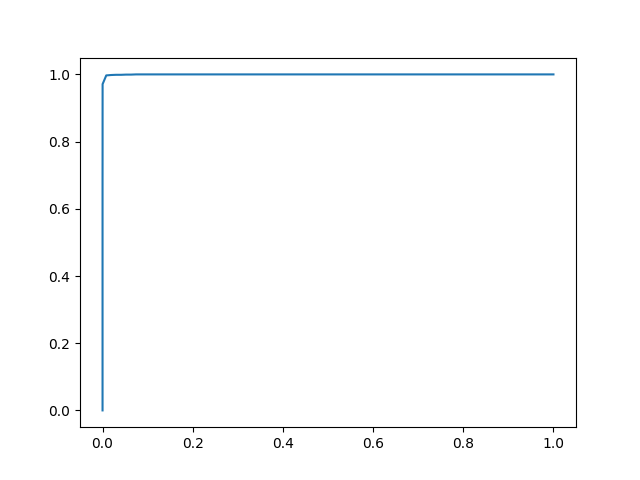

In [148]:
%%python
import pandas as pd
import matplotlib.pyplot as plt
import tempfile
from IPython.display import Image

roc = spark.sql("select * from roc")
rocPandas = roc.toPandas()
print(rocPandas.head())
plt.clf()
plt.plot(rocPandas['FPR'],rocPandas['TPR'])
with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

## Prediction on test set

In [149]:
val prediction = lr.transform(testData)
evaluatePrediction(prediction)

+-----+----------+--------+
|label|prediction|count(1)|
+-----+----------+--------+
|1    |0.0       |135     |
|0    |0.0       |3422    |
|1    |1.0       |293     |
|0    |1.0       |117     |
+-----+----------+--------+

+--------+---------+------+---+----+----+----+----+
|Accuracy|Precision|Recall|F1 |TPR |FPR |TNR |FNR |
+--------+---------+------+---+----+----+----+----+
|0.94    |0.71     |0.68  |0.7|0.68|0.03|0.97|0.32|
+--------+---------+------+---+----+----+----+----+



prediction: org.apache.spark.sql.DataFrame = [loan_amnt: int, term: string ... 103 more fields]


# Decision Tree fitting

In [150]:
// fitting decision tree model
val dt = runModel(trainingData,"dt",featureEngineeringPipeline = featureEngineeringPipeline)

val model = dt.stages(dt.stages.length-1).asInstanceOf[DecisionTreeClassificationModel]
val prediction = dt.transform(testData)

2019-06-10 06:29:59,579 WARN  [Executor task launch worker for task 2440] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_2064_0 in memory! (computed 121.0 MB so far)
2019-06-10 06:29:59,579 WARN  [Executor task launch worker for task 2440] storage.BlockManager (Logging.scala:logWarning(66)) - Persisting block rdd_2064_0 to disk instead.
2019-06-10 06:30:04,074 WARN  [Executor task launch worker for task 2440] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_2064_0 in memory! (computed 121.0 MB so far)
2019-06-10 06:30:04,806 WARN  [Executor task launch worker for task 2444] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_2064_0 in memory! (computed 121.0 MB so far)
2019-06-10 06:30:06,035 WARN  [Executor task launch worker for task 2448] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_2064_0 in memory! (computed 121.0 MB so far)
2019-06-10 06:30:07,110

dt: org.apache.spark.ml.PipelineModel = pipeline_b9b919409607
model: org.apache.spark.ml.classification.DecisionTreeClassificationModel = DecisionTreeClassificationModel (uid=dtc_e74d05ac488b) of depth 5 with 27 nodes
prediction: org.apache.spark.sql.DataFrame = [loan_amnt: int, term: string ... 103 more fields]


In [152]:
evaluatePrediction(prediction)

+-----+----------+--------+
|label|prediction|count(1)|
+-----+----------+--------+
|1    |0.0       |59      |
|0    |0.0       |3477    |
|1    |1.0       |369     |
|0    |1.0       |62      |
+-----+----------+--------+

+--------+---------+------+----+----+----+----+----+
|Accuracy|Precision|Recall|F1  |TPR |FPR |TNR |FNR |
+--------+---------+------+----+----+----+----+----+
|0.97    |0.86     |0.86  |0.86|0.86|0.02|0.98|0.14|
+--------+---------+------+----+----+----+----+----+



# Random Forest fitting

In [153]:
// fitting random forest model
val rf = runModel(trainingData,"rf",featureEngineeringPipeline = featureEngineeringPipeline)

val model = rf.stages(rf.stages.length-1).asInstanceOf[RandomForestClassificationModel]
val prediction = rf.transform(testData)

2019-06-10 06:31:34,129 WARN  [Executor task launch worker for task 2952] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_2329_0 in memory! (computed 121.5 MB so far)
2019-06-10 06:31:34,129 WARN  [Executor task launch worker for task 2952] storage.BlockManager (Logging.scala:logWarning(66)) - Persisting block rdd_2329_0 to disk instead.
2019-06-10 06:31:38,491 WARN  [Executor task launch worker for task 2952] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_2329_0 in memory! (computed 121.5 MB so far)
2019-06-10 06:31:40,473 WARN  [Executor task launch worker for task 2956] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_2329_0 in memory! (computed 121.5 MB so far)
2019-06-10 06:31:41,323 WARN  [Executor task launch worker for task 2960] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_2329_0 in memory! (computed 121.5 MB so far)
2019-06-10 06:31:42,622

rf: org.apache.spark.ml.PipelineModel = pipeline_95b0c78ce0e8
model: org.apache.spark.ml.classification.RandomForestClassificationModel = RandomForestClassificationModel (uid=rfc_c93a37305f88) with 20 trees
prediction: org.apache.spark.sql.DataFrame = [loan_amnt: int, term: string ... 103 more fields]


In [154]:
evaluatePrediction(prediction)

+-----+----------+--------+
|label|prediction|count(1)|
+-----+----------+--------+
|1    |0.0       |428     |
|0    |0.0       |3539    |
+-----+----------+--------+

+--------+---------+------+---+---+---+---+---+
|Accuracy|Precision|Recall|F1 |TPR|FPR|TNR|FNR|
+--------+---------+------+---+---+---+---+---+
|0.89    |null     |0.0   |0.0|0.0|0.0|1.0|1.0|
+--------+---------+------+---+---+---+---+---+



# Compare 3 models

| Model| Accuracy | Precision | Recall | F1 | TPR | FPR | TNR | FNR |
|------|------|------|------|------|------|------|------|------|
|   logistic  | 0.94    |0.71     |0.68  |0.7|0.68|0.03|0.97|0.32|
|   decision tree | 0.97    |0.86     |0.86  |0.86|0.86|0.02|0.98|0.14|
|   random forest | 0.89    |0.0     |0.0   |0.0|0.0|0.0|1.0|1.0|

Decistion Tree performs the best. Logistic Regression performs worse than decision tree in all metrics. Particularly, false negative rate of logistic regression is more than double of decistion tree model. Any falst negative imposes a much larger risk to the financial institution than false positive. 

Random forest somehow predicts all test set to be negative, so false negative rate is 100%. That shows random forest is not a good option for imbalance data.

# Inspect Logistic Regression Model Coefficients

## Get coefficient vector from logistic regression model

In [91]:
val coefficients = lrModel.coefficients.toArray.toList.toDF("coeff")

coefficients: org.apache.spark.sql.DataFrame = [coeff: double]


In [92]:
coefficients.describe().show()

+-------+-------------------+
|summary|              coeff|
+-------+-------------------+
|  count|               9357|
|   mean|-0.6311399599109841|
| stddev| 4.6152063028236565|
|    min| -25.31775747368051|
|    max|  33.80829819140034|
+-------+-------------------+



In [93]:
coefficients.createOrReplaceTempView("coeff")

      coeff
0 -0.581733
1 -0.093194
2  0.000000
3 -0.012962
4 -0.400287


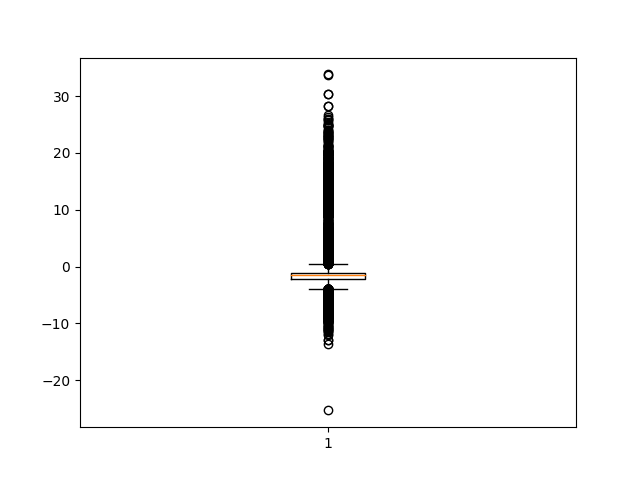

In [94]:
%%python
import pandas as pd
import matplotlib.pyplot as plt
import tempfile
from IPython.display import Image

coeff = spark.sql("select * from coeff")
coeffPandas = coeff.toPandas()
print(coeffPandas.head())
plt.clf()
plt.boxplot(coeffPandas['coeff'])
# plt.plot(rocPandas['FPR'],rocPandas['TPR'])
with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

In [95]:
coefficients.orderBy(desc("coeff")).show(10)

+------------------+
|             coeff|
+------------------+
| 33.80829819140034|
| 33.67597093272743|
|30.423092752416306|
|30.416448041835448|
|28.267026981802548|
|28.209291145071546|
|26.709100180462436|
|26.291729574207395|
|25.964803675223084|
|25.882539240953996|
+------------------+
only showing top 10 rows



In [96]:
coefficients.orderBy(asc("coeff")).show(10)

+-------------------+
|              coeff|
+-------------------+
| -25.31775747368051|
|-13.593201705928879|
|-12.999584346008902|
|-12.914881566872252|
|-11.979821746507612|
|-11.800584923440665|
|-11.583361620924641|
|-11.336507863448887|
|-11.309337704739656|
|-11.155833609844997|
+-------------------+
only showing top 10 rows



## Look for the feature vector indexes of 10 largest and smallest coefficients


In [97]:
val coefficientsArr = lrModel.coefficients.toArray

coefficientsArr: Array[Double] = Array(-0.5817333520261013, -0.09319441016785333, 0.0, -0.012962161513120643, -0.40028730813228497, -0.6596954275443337, 0.34224727534728666, 0.3502627341477298, -0.508221684496821, 0.5182175564423831, 0.0, -0.03586827107467746, -0.2501432329723487, 0.1297987638152875, -0.29598326430026456, 0.20742158592522097, -0.05442095192904407, 0.19437938049190415, -0.766536948125595, -0.5863384675132409, -0.10291657793085895, -0.2604319394646912, -0.8473043423862151, -0.1494627530598978, -0.6037828526192519, -0.03317296516896737, 0.34967210973328955, 0.9584104062742723, -1.0321213014129715, -0.20912208668079782, 0.2484154176274044, 0.6125401077806583, -1.032765271512543, 1.071649283466267, 0.19905613623060409, 1.2250095218674764, -1.6264511209004122, -0.093852252959...

In [98]:
val lowestIndex = for { i <- coefficientsArr.zipWithIndex
     if i._1 < -11.155833609844997} yield i._2

lowestIndex: Array[Int] = Array(723, 2433, 2539, 4039, 4568, 5385, 5671, 7386, 7423)


In [100]:
lowestIndex.max

res23: Int = 7423


In [99]:
val highestIndex = for { i <- coefficientsArr.zipWithIndex
     if i._1 > 25.882539240953996} yield i._2

highestIndex: Array[Int] = Array(1733, 2010, 2195, 3801, 4824, 5247, 5561, 5874, 7409)


In [101]:
highestIndex.max

res24: Int = 7409


## Look at how the feature vector been created

In [105]:
allFeatureColumns.foreach{ f =>
    prediction.select(f).show(5,false)
}

+-------------+
|term_vec     |
+-------------+
|(3,[0],[1.0])|
|(3,[0],[1.0])|
|(3,[0],[1.0])|
|(3,[0],[1.0])|
|(3,[0],[1.0])|
+-------------+
only showing top 5 rows

+-------------+
|grade_vec    |
+-------------+
|(8,[2],[1.0])|
|(8,[2],[1.0])|
|(8,[2],[1.0])|
|(8,[1],[1.0])|
|(8,[1],[1.0])|
+-------------+
only showing top 5 rows

+---------------+
|sub_grade_vec  |
+---------------+
|(36,[11],[1.0])|
|(36,[11],[1.0])|
|(36,[11],[1.0])|
|(36,[5],[1.0]) |
|(36,[7],[1.0]) |
+---------------+
only showing top 5 rows

+-------------------+
|emp_title_vec      |
+-------------------+
|(7715,[7714],[1.0])|
|(7715,[7714],[1.0])|
|(7715,[5418],[1.0])|
|(7715,[616],[1.0]) |
|(7715,[7714],[1.0])|
+-------------------+
only showing top 5 rows

+---------------+
|emp_length_vec |
+---------------+
|(13,[4],[1.0]) |
|(13,[0],[1.0]) |
|(13,[3],[1.0]) |
|(13,[10],[1.0])|
|(13,[0],[1.0]) |
+---------------+
only showing top 5 rows

+------------------+
|home_ownership_vec|
+------------------+
|(

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
only showing top 5 rows



#### length of feature vector for catogirical variables
```
term_vec: 3
grade_vec: 8
sub_grade_vec: 36
emp_title_vec: 9192
emp_length_vec: 13
home_ownership_vec: 5
verification_status_vec: 4
issue_d_vec: 13
purpose_vec: 13
title_vec: 13
zip_code_vec: 835
addr_state_vec: 51
earliest_cr_line_vec: 563
initial_list_status_vec: 3
last_pymnt_d_vec: 27
last_credit_pull_d_vec: 27
application_type_vec: 3
```

#### numerical vector order

In [106]:
numericColumns.foreach(println)

loan_amnt
int_rate
annual_inc
dti
delinq_2yrs
inq_last_6mths
open_acc
pub_rec
revol_bal
revol_util
total_acc
out_prncp
total_pymnt
total_rec_int
total_rec_late_fee
collection_recovery_fee
last_pymnt_amnt
collections_12_mths_ex_med
policy_code
acc_now_delinq
tot_coll_amt
tot_cur_bal
total_rev_hi_lim
acc_open_past_24mths
chargeoff_within_12_mths
delinq_amnt
mo_sin_old_il_acct
mo_sin_old_rev_tl_op
mo_sin_rcnt_rev_tl_op
mo_sin_rcnt_tl
mort_acc
mths_since_recent_bc
num_accts_ever_120_pd
num_actv_rev_tl
num_bc_sats
num_il_tl
num_rev_accts
num_sats
num_tl_120dpd_2m
num_tl_90g_dpd_24m
num_tl_op_past_12m
pct_tl_nvr_dlq
percent_bc_gt_75
pub_rec_bankruptcies
tax_liens
tot_hi_cred_lim
total_il_high_credit_limit


In [107]:
numericColumns.length

res30: Int = 47


#### Length of feature vectors = Length of coeff vector
* catogirical var = 3+8+36+9192+13+5+4+13+13+13+835+51+563+3+27+27+3 = 10809
* numeric var = 47
* total = 10809+47 = 10856

All the top 10 largest and smallest coefficients indexes are with the one hot encoder vector range of string field 'emp_title'

Now try to feed only emp_title field into logistic regression to see what happens

## Using onle emp_title for training

In [155]:
val categoricalFeatures = Array("emp_title").flatMap{ name =>
    
    val stringIndexer = new StringIndexer()
      .setInputCol(name)
      .setOutputCol(name + "_index")
      .setHandleInvalid("keep")
    
    val oneHotEncoder = new OneHotEncoderEstimator()
      .setInputCols(Array(name + "_index"))
      .setOutputCols(Array(name + "_vec"))
      .setDropLast(false)
    
    Array(stringIndexer, oneHotEncoder)
}

val allFeatureColumns = Array("emp_title").map(x => x + "_vec")
val featureColumnsAssembler = new VectorAssembler()
  .setInputCols(allFeatureColumns)
  .setOutputCol("features")

var featureEngineeringPipeline = Array[org.apache.spark.ml.PipelineStage]()
featureEngineeringPipeline = featureEngineeringPipeline ++ categoricalFeatures
featureEngineeringPipeline = featureEngineeringPipeline ++ Array(featureColumnsAssembler)

categoricalFeatures: Array[org.apache.spark.ml.Estimator[_ >: org.apache.spark.ml.feature.OneHotEncoderModel with org.apache.spark.ml.feature.StringIndexerModel <: org.apache.spark.ml.Model[_ >: org.apache.spark.ml.feature.OneHotEncoderModel with org.apache.spark.ml.feature.StringIndexerModel <: org.apache.spark.ml.Transformer with org.apache.spark.ml.param.shared.HasHandleInvalid with org.apache.spark.ml.util.MLWritable] with org.apache.spark.ml.param.shared.HasHandleInvalid with org.apache.spark.ml.util.MLWritable] with org.apache.spark.ml.param.shared.HasHandleInvalid with org.apache.spark.ml.util.DefaultParamsWritable{def copy(extra: org.apache.spark.ml.param.ParamMap): org.apache.spark.ml.Estimator[_ >: org.apache.spark.ml.feature.OneHotEncoderModel with org.apache.spark.ml.feature...

In [156]:
// Fit the logistic regression model 
val lr = runModel(trainingData,"lr",featureEngineeringPipeline = featureEngineeringPipeline)
val lrModel = lr.stages(lr.stages.length-1).asInstanceOf[LogisticRegressionModel]

lr: org.apache.spark.ml.PipelineModel = pipeline_adfda3686e93
lrModel: org.apache.spark.ml.classification.LogisticRegressionModel = LogisticRegressionModel: uid = logreg_67dcb834aee8, numClasses = 2, numFeatures = 7715


In [157]:
// Evaluate Model
val trainingSummary = lrModel.binarySummary
val accuracy = trainingSummary.accuracy
val falsePositiveRate = trainingSummary.weightedFalsePositiveRate
val truePositiveRate = trainingSummary.weightedTruePositiveRate
val fMeasure = trainingSummary.weightedFMeasure
val precision = trainingSummary.weightedPrecision
val recall = trainingSummary.weightedRecall
println(s"Accuracy: $accuracy\nFPR: $falsePositiveRate\nTPR: $truePositiveRate\n" +
  s"F-measure: $fMeasure\nPrecision: $precision\nRecall: $recall")
val roc = trainingSummary.roc
roc.createOrReplaceTempView("roc")
roc.show()
println(s"areaUnderROC: ${trainingSummary.areaUnderROC}")

val prediction = lr.transform(testData)
evaluatePrediction(prediction)

Accuracy: 0.9352294603490033
FPR: 0.5584276402093028
TPR: 0.9352294603490033
F-measure: 0.9219273540736255
Precision: 0.9383653479593199
Recall: 0.9352294603490033
+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|                 0.0|0.001809408926417...|
|                 0.0|0.005428226779252111|
|                 0.0|   0.364897466827503|
|4.153686396677051E-4|  0.3721351025331725|
|6.230529595015577E-4| 0.37575392038600725|
| 7.61509172724126E-4|  0.3775633293124246|
|9.691934925579786E-4|   0.379372738238842|
|0.001246105919003...| 0.38178528347406515|
|0.001661474558670...|  0.3854041013268999|
|0.001938386985115...| 0.38781664656212306|
|0.008168916580131533| 0.44209891435464416|
| 0.00844582900657667|  0.4439083232810615|
|0.008722741433021807|  0.4457177322074789|
|0.009207338179300795|  0.4487334137515078|
|0.010661128418137765|  0.4571773220747889|


trainingSummary: org.apache.spark.ml.classification.BinaryLogisticRegressionTrainingSummary = org.apache.spark.ml.classification.BinaryLogisticRegressionTrainingSummaryImpl@a46c0bd
accuracy: Double = 0.9352294603490033
falsePositiveRate: Double = 0.5584276402093028
truePositiveRate: Double = 0.9352294603490033
fMeasure: Double = 0.9219273540736255
precision: Double = 0.9383653479593199
recall: Double = 0.9352294603490033
roc: org.apache.spark.sql.DataFrame = [FPR: double, TPR: double]
prediction: org.apache.spark.sql.DataFrame = [loan_amnt: int, term: string ... 69 more fields]


        FPR       TPR
0  0.000000  0.000000
1  0.000000  0.001809
2  0.000000  0.005428
3  0.000000  0.364897
4  0.000415  0.372135


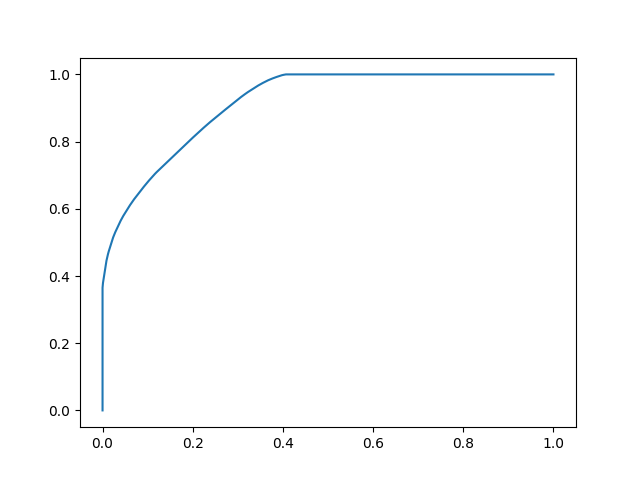

In [159]:
%%python
import pandas as pd
import matplotlib.pyplot as plt
import tempfile
from IPython.display import Image

roc = spark.sql("select * from roc")
rocPandas = roc.toPandas()
print(rocPandas.head())
plt.clf()
plt.plot(rocPandas['FPR'],rocPandas['TPR'])
with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

## Observation

Using only the `emp_title` field for training still achives good result in training, while model performs poorly in test set:

| Data| Accuracy | Precision | Recall | F1 |
|------|------|------|------|------|
|   Training Set  | 0.94    |0.94     |0.94  |0.92|
|   Test Set | 0.89    |0.24     |0.02  |0.03|


That suggestes the model performs very well on training data but has high error rates on test data, due to the model has
* high variance
* low bias